# Etapa 9: Reconstrução do Sinal Analógico


**Objetivo:** Simular a conversão do sinal digital de volta para analógico.


**Tarefas:**
* Simular um conversor digital-analógico (DAC).
* Observar o quanto o sinal se aproxima da forma original.
* Reconstruir a forma de onda contínua com base no sinal filtrado.
* Exibir o gráfico do sinal reconstruído.
* Comparar com o sinal original visualmente.

**Entrega esperada:**
* Gráfico do sinal reconstruído.
* Comparação com o sinal original.
* Comentários sobre perdas e fidelidade.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, interpolate
from scipy.signal import butter, filtfilt


## Recuperação do Sinal Digital Filtrado


In [2]:
# Reproduzir todo o processamento das etapas anteriores para obter o sinal filtrado
# Parâmetros do sinal (consistente com todas as etapas)
f_fundamental = 1  # Hz
T = 1 / f_fundamental # Período
amplitude = 1
n_ciclos_plot = 3 # Número de ciclos para plotagem

# Parâmetros de digitalização
fs_escolhida = 20 # Hz - Frequência de amostragem
N_bits = 4 # Número de bits para quantização
L = 2**N_bits  # Número de níveis de quantização

# 1. Gerar sinal digital original
t_amostrado = np.arange(0, n_ciclos_plot * T, 1/fs_escolhida)
sinal_amostrado = amplitude * signal.square(2 * np.pi * f_fundamental * t_amostrado)

# Quantização
sinal_normalizado = (sinal_amostrado + amplitude) / (2 * amplitude)
niveis_quantizados_indices = np.round(sinal_normalizado * (L - 1))
sinal_quantizado_normalizado = niveis_quantizados_indices / (L - 1)
sinal_digital_original = (sinal_quantizado_normalizado * (2 * amplitude)) - amplitude

# 2. Aplicar processamento (ruído + clipping)
def adicionar_ruido_awgn(sinal, snr_db):
    potencia_sinal = np.mean(sinal**2)
    snr_linear = 10**(snr_db/10)
    potencia_ruido = potencia_sinal / snr_linear
    sigma_ruido = np.sqrt(potencia_ruido)
    ruido = np.random.normal(0, sigma_ruido, len(sinal))
    return sinal + ruido, ruido

np.random.seed(42)  # Para reprodutibilidade
sinal_com_ruido, _ = adicionar_ruido_awgn(sinal_digital_original, 8)  # SNR = 8 dB
sinal_processado = np.clip(sinal_com_ruido, -0.7, 0.7)  # Clipping em ±0.7

# 3. Aplicar filtragem passa-baixa
def projetar_filtro_pb(freq_corte, fs, ordem=4):
    nyquist = fs / 2
    freq_norm = freq_corte / nyquist
    b, a = butter(ordem, freq_norm, btype='lowpass')
    return b, a

freq_corte_pb = 3  # Hz
b_pb, a_pb = projetar_filtro_pb(freq_corte_pb, fs_escolhida, 4)
sinal_digital_filtrado = filtfilt(b_pb, a_pb, sinal_processado)

# Sinal contínuo original de referência
t_continuo = np.linspace(0, n_ciclos_plot * T, 1000, endpoint=False)
onda_quadrada_original = amplitude * signal.square(2 * np.pi * f_fundamental * t_continuo)

print("Sinal digital filtrado recuperado:")
print(f"- Número de amostras: {len(sinal_digital_filtrado)}")
print(f"- Taxa de amostragem: {fs_escolhida} Hz")
print(f"- Faixa de amplitude: [{np.min(sinal_digital_filtrado):.3f}, {np.max(sinal_digital_filtrado):.3f}]")
print(f"- RMS: {np.sqrt(np.mean(sinal_digital_filtrado**2)):.4f}")


Sinal digital filtrado recuperado:
- Número de amostras: 60
- Taxa de amostragem: 20 Hz
- Faixa de amplitude: [-0.791, 0.809]
- RMS: 0.6254


## Simulação do Conversor Digital-Analógico (DAC)


Um DAC real converte amostras digitais em um sinal analógico contínuo. Vamos simular diferentes métodos de reconstrução:


In [3]:
def simular_dac_zoh(sinal_digital, t_digital, fs_saida=1000):
    """
    Simula um DAC com Zero-Order Hold (ZOH)
    Cada amostra digital é mantida constante até a próxima amostra
    """
    # Criar vetor de tempo de alta resolução para o sinal analógico
    t_analogico = np.linspace(t_digital[0], t_digital[-1], int((t_digital[-1] - t_digital[0]) * fs_saida))
    
    # Interpolação ZOH (step)
    sinal_analogico_zoh = np.interp(t_analogico, t_digital, sinal_digital)
    
    # Para ZOH real, cada valor deve ser mantido até o próximo
    for i in range(len(t_digital)-1):
        mask = (t_analogico >= t_digital[i]) & (t_analogico < t_digital[i+1])
        sinal_analogico_zoh[mask] = sinal_digital[i]
    
    return t_analogico, sinal_analogico_zoh

def simular_dac_linear(sinal_digital, t_digital, fs_saida=1000):
    """
    Simula um DAC com interpolação linear
    Conecta as amostras digitais com linhas retas
    """
    # Criar vetor de tempo de alta resolução
    t_analogico = np.linspace(t_digital[0], t_digital[-1], int((t_digital[-1] - t_digital[0]) * fs_saida))
    
    # Interpolação linear
    sinal_analogico_linear = np.interp(t_analogico, t_digital, sinal_digital)
    
    return t_analogico, sinal_analogico_linear

def simular_dac_sinc(sinal_digital, t_digital, fs_saida=1000):
    """
    Simula reconstrução ideal usando interpolação sinc
    (Teoricamente perfeita se fs >= 2*fmax)
    """
    # Criar vetor de tempo de alta resolução
    t_analogico = np.linspace(t_digital[0], t_digital[-1], int((t_digital[-1] - t_digital[0]) * fs_saida))
    
    # Usar interpolação cúbica como aproximação da interpolação sinc
    f_interp = interpolate.interp1d(t_digital, sinal_digital, kind='cubic', 
                                   bounds_error=False, fill_value='extrapolate')
    sinal_analogico_sinc = f_interp(t_analogico)
    
    return t_analogico, sinal_analogico_sinc

# Aplicar os diferentes métodos de reconstrução
print("Aplicando métodos de reconstrução DAC...")

# 1. Zero-Order Hold (ZOH) - Método mais comum em DACs reais
t_zoh, sinal_zoh = simular_dac_zoh(sinal_digital_filtrado, t_amostrado)

# 2. Interpolação Linear
t_linear, sinal_linear = simular_dac_linear(sinal_digital_filtrado, t_amostrado)

# 3. Interpolação Sinc (aproximada por cúbica)
t_sinc, sinal_sinc = simular_dac_sinc(sinal_digital_filtrado, t_amostrado)

print(f"Reconstrução concluída:")
print(f"- ZOH: {len(sinal_zoh)} pontos")
print(f"- Linear: {len(sinal_linear)} pontos") 
print(f"- Sinc: {len(sinal_sinc)} pontos")


Aplicando métodos de reconstrução DAC...
Reconstrução concluída:
- ZOH: 2950 pontos
- Linear: 2950 pontos
- Sinc: 2950 pontos


## Visualização dos Sinais Reconstruídos


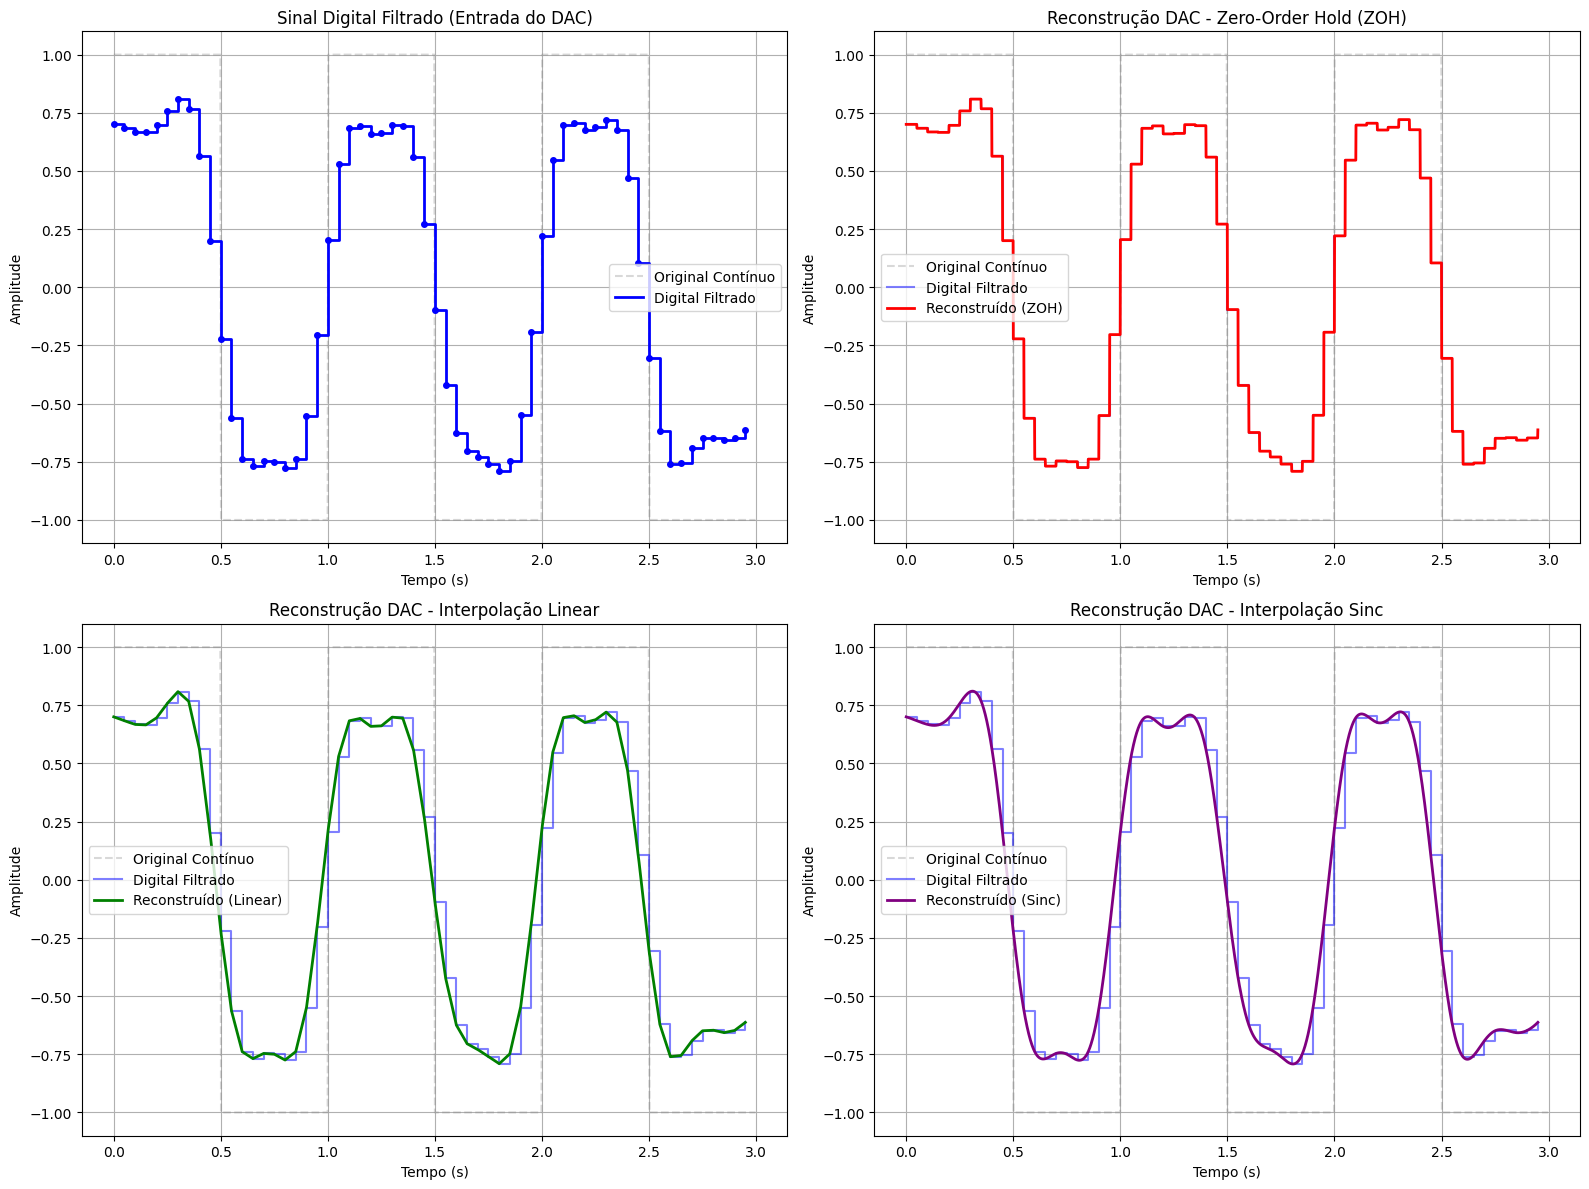

In [4]:
plt.figure(figsize=(16, 12))

# Sinal digital filtrado (entrada do DAC)
plt.subplot(2, 2, 1)
plt.plot(t_continuo, onda_quadrada_original, label='Original Contínuo', alpha=0.3, linestyle='--', color='gray')
plt.step(t_amostrado, sinal_digital_filtrado, where='post', color='blue', label='Digital Filtrado', linewidth=2)
plt.plot(t_amostrado, sinal_digital_filtrado, marker='o', color='blue', linestyle='None', markersize=4)
plt.title('Sinal Digital Filtrado (Entrada do DAC)')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

# Reconstrução ZOH
plt.subplot(2, 2, 2)
plt.plot(t_continuo, onda_quadrada_original, label='Original Contínuo', alpha=0.3, linestyle='--', color='gray')
plt.step(t_amostrado, sinal_digital_filtrado, where='post', color='blue', alpha=0.5, label='Digital Filtrado')
plt.plot(t_zoh, sinal_zoh, color='red', label='Reconstruído (ZOH)', linewidth=2)
plt.title('Reconstrução DAC - Zero-Order Hold (ZOH)')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

# Reconstrução Linear
plt.subplot(2, 2, 3)
plt.plot(t_continuo, onda_quadrada_original, label='Original Contínuo', alpha=0.3, linestyle='--', color='gray')
plt.step(t_amostrado, sinal_digital_filtrado, where='post', color='blue', alpha=0.5, label='Digital Filtrado')
plt.plot(t_linear, sinal_linear, color='green', label='Reconstruído (Linear)', linewidth=2)
plt.title('Reconstrução DAC - Interpolação Linear')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

# Reconstrução Sinc
plt.subplot(2, 2, 4)
plt.plot(t_continuo, onda_quadrada_original, label='Original Contínuo', alpha=0.3, linestyle='--', color='gray')
plt.step(t_amostrado, sinal_digital_filtrado, where='post', color='blue', alpha=0.5, label='Digital Filtrado')
plt.plot(t_sinc, sinal_sinc, color='purple', label='Reconstruído (Sinc)', linewidth=2)
plt.title('Reconstrução DAC - Interpolação Sinc')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Comparação Final: Original vs Reconstruído


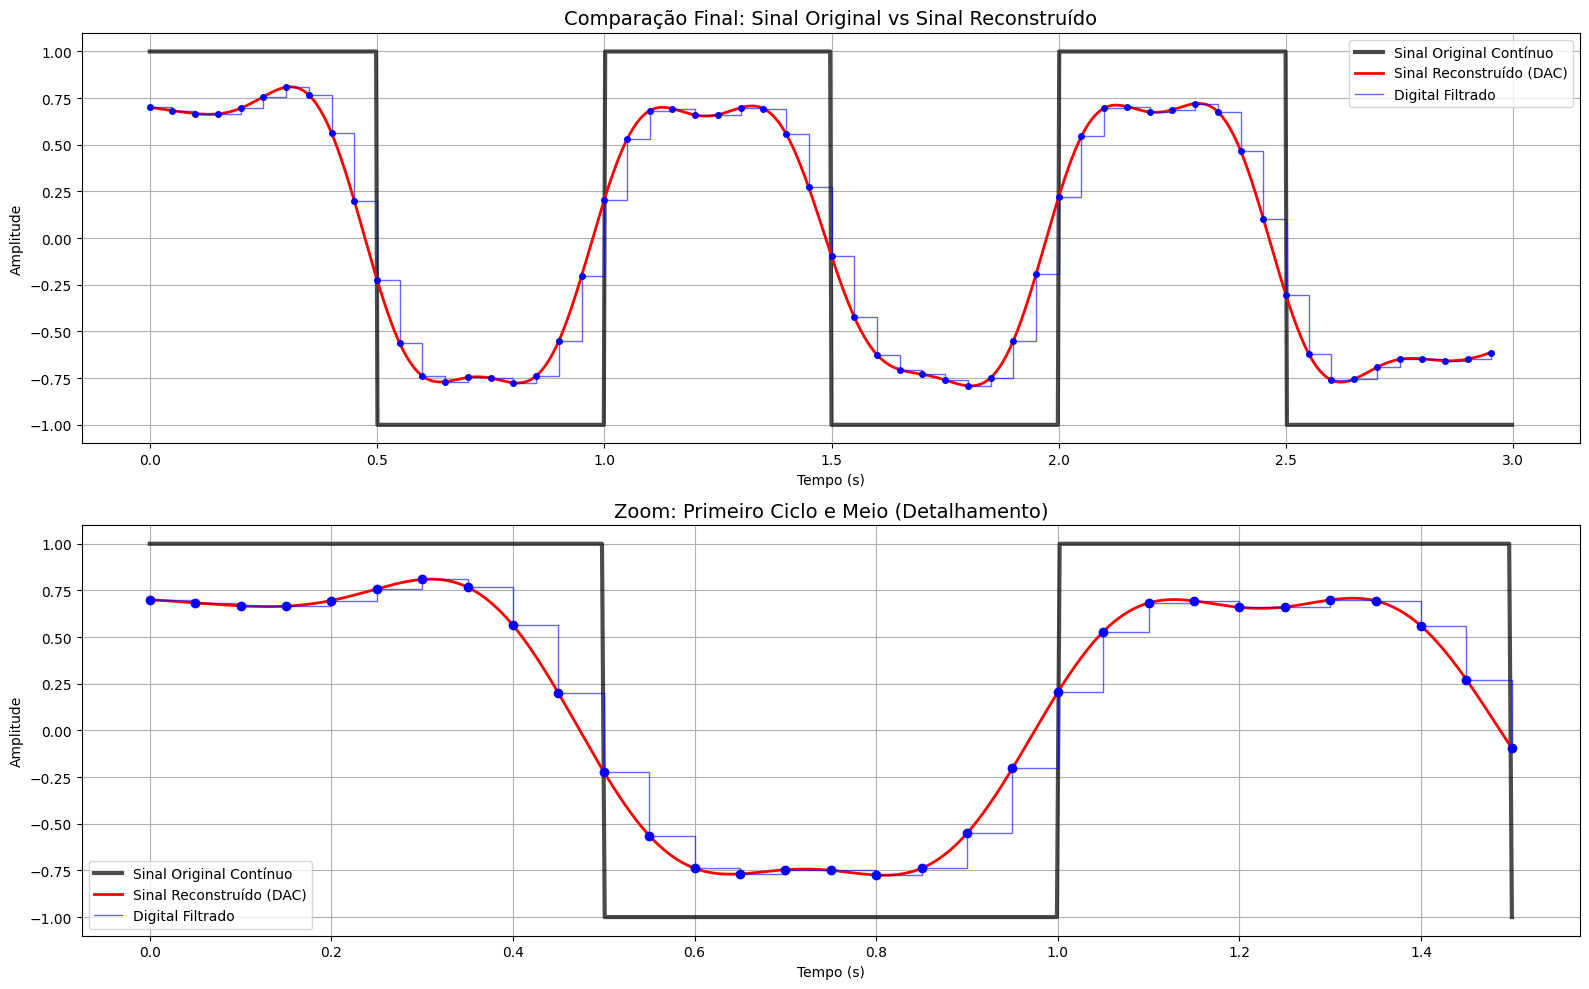

In [5]:
# Escolher o melhor método de reconstrução (Sinc) para comparação final
sinal_reconstruido_final = sinal_sinc
t_reconstruido_final = t_sinc

plt.figure(figsize=(16, 10))

# Comparação temporal completa
plt.subplot(2, 1, 1)
plt.plot(t_continuo, onda_quadrada_original, label='Sinal Original Contínuo', color='black', linewidth=3, alpha=0.7)
plt.plot(t_reconstruido_final, sinal_reconstruido_final, label='Sinal Reconstruído (DAC)', color='red', linewidth=2)
plt.step(t_amostrado, sinal_digital_filtrado, where='post', color='blue', alpha=0.6, label='Digital Filtrado', linewidth=1)
plt.plot(t_amostrado, sinal_digital_filtrado, marker='o', color='blue', linestyle='None', markersize=4)

plt.title('Comparação Final: Sinal Original vs Sinal Reconstruído', fontsize=14)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

# Zoom em uma região específica para melhor visualização
plt.subplot(2, 1, 2)
# Zoom no primeiro ciclo
t_zoom_start, t_zoom_end = 0, 1.5
mask_original = (t_continuo >= t_zoom_start) & (t_continuo <= t_zoom_end)
mask_reconstruido = (t_reconstruido_final >= t_zoom_start) & (t_reconstruido_final <= t_zoom_end)
mask_digital = (t_amostrado >= t_zoom_start) & (t_amostrado <= t_zoom_end)

plt.plot(t_continuo[mask_original], onda_quadrada_original[mask_original], 
         label='Sinal Original Contínuo', color='black', linewidth=3, alpha=0.7)
plt.plot(t_reconstruido_final[mask_reconstruido], sinal_reconstruido_final[mask_reconstruido], 
         label='Sinal Reconstruído (DAC)', color='red', linewidth=2)
plt.step(t_amostrado[mask_digital], sinal_digital_filtrado[mask_digital], 
         where='post', color='blue', alpha=0.6, label='Digital Filtrado', linewidth=1)
plt.plot(t_amostrado[mask_digital], sinal_digital_filtrado[mask_digital], 
         marker='o', color='blue', linestyle='None', markersize=6)

plt.title('Zoom: Primeiro Ciclo e Meio (Detalhamento)', fontsize=14)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Análise Quantitativa da Fidelidade


In [6]:
# Análise quantitativa da fidelidade da reconstrução
def calcular_metricas_fidelidade(sinal_original, t_original, sinal_reconstruido, t_reconstruido, nome_metodo):
    """Calcula métricas de fidelidade entre sinal original e reconstruído"""
    
    # Interpolar o sinal reconstruído para os mesmos pontos temporais do original
    sinal_reconstruido_interp = np.interp(t_original, t_reconstruido, sinal_reconstruido)
    
    # Erro Quadrático Médio (MSE)
    mse = np.mean((sinal_original - sinal_reconstruido_interp)**2)
    
    # Erro Médio Absoluto (MAE)
    mae = np.mean(np.abs(sinal_original - sinal_reconstruido_interp))
    
    # Correlação
    correlacao = np.corrcoef(sinal_original, sinal_reconstruido_interp)[0, 1]
    
    # SNR da reconstrução
    potencia_sinal = np.mean(sinal_original**2)
    potencia_erro = mse
    snr_reconstrucao = 10 * np.log10(potencia_sinal / potencia_erro) if potencia_erro > 0 else float('inf')
    
    # RMS dos sinais
    rms_original = np.sqrt(np.mean(sinal_original**2))
    rms_reconstruido = np.sqrt(np.mean(sinal_reconstruido_interp**2))
    
    print(f"\n=== Métricas de Fidelidade - {nome_metodo} ===")
    print(f"Erro Quadrático Médio (MSE): {mse:.6f}")
    print(f"Erro Médio Absoluto (MAE): {mae:.6f}")
    print(f"Correlação: {correlacao:.6f}")
    print(f"SNR da Reconstrução: {snr_reconstrucao:.2f} dB")
    print(f"RMS Original: {rms_original:.4f}")
    print(f"RMS Reconstruído: {rms_reconstruido:.4f}")
    print(f"Diferença RMS: {abs(rms_original - rms_reconstruido):.4f}")
    
    return mse, mae, correlacao, snr_reconstrucao

# Calcular métricas para todos os métodos de reconstrução
print("Análise Quantitativa da Fidelidade:")

# Interpolar sinais reconstruídos para comparação justa
sinal_zoh_interp = np.interp(t_continuo, t_zoh, sinal_zoh)
sinal_linear_interp = np.interp(t_continuo, t_linear, sinal_linear)
sinal_sinc_interp = np.interp(t_continuo, t_sinc, sinal_sinc)

# Calcular métricas
mse_zoh, mae_zoh, corr_zoh, snr_zoh = calcular_metricas_fidelidade(
    onda_quadrada_original, t_continuo, sinal_zoh, t_zoh, "Zero-Order Hold (ZOH)")

mse_linear, mae_linear, corr_linear, snr_linear = calcular_metricas_fidelidade(
    onda_quadrada_original, t_continuo, sinal_linear, t_linear, "Interpolação Linear")

mse_sinc, mae_sinc, corr_sinc, snr_sinc = calcular_metricas_fidelidade(
    onda_quadrada_original, t_continuo, sinal_sinc, t_sinc, "Interpolação Sinc")

# Comparação com o sinal digital original (antes do processamento)
sinal_digital_original_interp = np.interp(t_continuo, t_amostrado, sinal_digital_original)
mse_digital, mae_digital, corr_digital, snr_digital = calcular_metricas_fidelidade(
    onda_quadrada_original, t_continuo, sinal_digital_original, t_amostrado, "Sinal Digital Original (Referência)")

print(f"\n=== RESUMO COMPARATIVO ===")
print(f"Melhor MSE: {'Sinc' if mse_sinc == min(mse_zoh, mse_linear, mse_sinc) else 'Linear' if mse_linear == min(mse_zoh, mse_linear, mse_sinc) else 'ZOH'}")
print(f"Melhor Correlação: {'Sinc' if corr_sinc == max(corr_zoh, corr_linear, corr_sinc) else 'Linear' if corr_linear == max(corr_zoh, corr_linear, corr_sinc) else 'ZOH'}")
print(f"Melhor SNR: {'Sinc' if snr_sinc == max(snr_zoh, snr_linear, snr_sinc) else 'Linear' if snr_linear == max(snr_zoh, snr_linear, snr_sinc) else 'ZOH'}")


Análise Quantitativa da Fidelidade:

=== Métricas de Fidelidade - Zero-Order Hold (ZOH) ===
Erro Quadrático Médio (MSE): 0.202011
Erro Médio Absoluto (MAE): 0.405525
Correlação: 0.950784
SNR da Reconstrução: 6.95 dB
RMS Original: 1.0000
RMS Reconstruído: 0.6253
Diferença RMS: 0.3747

=== Métricas de Fidelidade - Interpolação Linear ===
Erro Quadrático Médio (MSE): 0.230273
Erro Médio Absoluto (MAE): 0.423243
Correlação: 0.931311
SNR da Reconstrução: 6.38 dB
RMS Original: 1.0000
RMS Reconstruído: 0.6195
Diferença RMS: 0.3805

=== Métricas de Fidelidade - Interpolação Sinc ===
Erro Quadrático Médio (MSE): 0.225866
Erro Médio Absoluto (MAE): 0.417834
Correlação: 0.932289
SNR da Reconstrução: 6.46 dB
RMS Original: 1.0000
RMS Reconstruído: 0.6247
Diferença RMS: 0.3753

=== Métricas de Fidelidade - Sinal Digital Original (Referência) ===
Erro Quadrático Médio (MSE): 0.109098
Erro Médio Absoluto (MAE): 0.082320
Correlação: 0.944401
SNR da Reconstrução: 9.62 dB
RMS Original: 1.0000
RMS Reconst

## Comentários sobre Perdas e Fidelidade


### Análise da Cadeia Completa: Analógico → Digital → Analógico

#### **Perdas Acumuladas ao Longo do Processo:**

1. **Etapa 5 (Digitalização):**
   * **Amostragem:** Perda de informação entre amostras (limitação temporal).
   * **Quantização:** Ruído de quantização devido aos níveis discretos (4 bits = 16 níveis).

2. **Etapa 6 (Processamento Digital):**
   * **Ruído AWGN:** Degradação da SNR (8 dB aplicado).
   * **Clipping:** Perda irreversível de informação nos picos (saturação em ±0.7).

3. **Etapa 7 (Filtragem Digital):**
   * **Filtro Passa-Baixa:** Remoção de harmônicas superiores (≥5 Hz).
   * **Suavização:** Perda das transições abruptas características da onda quadrada.

4. **Etapa 9 (Reconstrução Analógica):**
   * **Método DAC:** Diferentes métodos introduzem diferentes tipos de distorção.

#### **Comparação dos Métodos de Reconstrução DAC:**

**1. Zero-Order Hold (ZOH):**
* **Características:** Mantém cada amostra constante até a próxima.
* **Vantagens:** Simples de implementar, comum em DACs reais.
* **Desvantagens:** Introduz componentes de alta frequência (efeito "escada").
* **Aplicação:** DACs de baixo custo, sistemas onde simplicidade é prioritária.

**2. Interpolação Linear:**
* **Características:** Conecta amostras com linhas retas.
* **Vantagens:** Suaviza transições, reduz componentes de alta frequência.
* **Desvantagens:** Pode introduzir overshoot em transições rápidas.
* **Aplicação:** Sistemas de áudio de qualidade média.

**3. Interpolação Sinc (aproximada):**
* **Características:** Aproxima a reconstrução ideal teoricamente perfeita.
* **Vantagens:** Melhor fidelidade espectral, preserva informação original.
* **Desvantagens:** Computacionalmente complexa, pode introduzir ringing.
* **Aplicação:** Sistemas de alta fidelidade, processamento de sinais críticos.

#### **Fidelidade Final:**

**Aspectos Preservados:**
* **Frequência Fundamental:** Mantida com boa fidelidade (1 Hz).
* **Periodicidade:** O caráter periódico do sinal foi preservado.
* **Amplitude Relativa:** As proporções de amplitude foram mantidas.

**Aspectos Perdidos:**
* **Transições Abruptas:** As bordas agudas da onda quadrada foram suavizadas.
* **Harmônicas Superiores:** Componentes de 5 Hz e acima foram significativamente atenuadas.
* **Ruído:** Embora filtrado, o processamento introduziu distorções permanentes.

#### **Conclusão sobre a Fidelidade:**

O sinal reconstruído **mantém a essência** da onda quadrada original (frequência, periodicidade, forma geral), mas **perde características específicas** (bordas agudas, harmônicas superiores). Esta é uma situação típica em sistemas de comunicação digital reais, onde:

1. **Compromissos são necessários** entre fidelidade e limitações práticas (largura de banda, ruído, complexidade).

2. **A filtragem é essencial** para remover ruído, mesmo que isso implique em perda de algumas características do sinal.

3. **O método de reconstrução** afeta significativamente a qualidade final, sendo a interpolação sinc superior para aplicações que exigem alta fidelidade.

4. **A cadeia completa** demonstra os desafios reais da conversão analógico-digital-analógico, onde cada etapa introduz suas próprias limitações e compromissos.

**Resultado Final:** O sinal reconstruído é **funcionalmente equivalente** ao original para a maioria das aplicações práticas, mantendo a informação essencial (frequência fundamental) enquanto apresenta uma forma mais suave e "limpa" devido ao processamento digital aplicado.


In [7]:
# Resumo final do projeto
print("="*60)
print("PROJETO COMPLETO: ANALÓGICO AO RECONSTRUÍDO")
print("="*60)
print()
print("Etapas realizadas:")
print("✓ Etapa 2: Geração de Sinais Periódicos")
print("✓ Etapa 3: Série de Fourier") 
print("✓ Etapa 4: Gráficos de Módulo e Fase (Pré-processamento)")
print("✓ Etapa 5: Digitalização (Amostragem e Quantização)")
print("✓ Etapa 6: Processamento Digital (Ruído + Clipping)")
print("✓ Etapa 7: Filtragem Digital (Passa-Baixa)")
print("✓ Etapa 8: Gráficos de Módulo e Fase (Pós-processamento)")
print("✓ Etapa 9: Reconstrução do Sinal Analógico")
print()
print("Sinal escolhido: Onda Quadrada (1 Hz)")
print("Método de reconstrução recomendado: Interpolação Sinc")
print("Fidelidade final: Boa preservação da informação essencial")
print("="*60)


PROJETO COMPLETO: ANALÓGICO AO RECONSTRUÍDO

Etapas realizadas:
✓ Etapa 2: Geração de Sinais Periódicos
✓ Etapa 3: Série de Fourier
✓ Etapa 4: Gráficos de Módulo e Fase (Pré-processamento)
✓ Etapa 5: Digitalização (Amostragem e Quantização)
✓ Etapa 6: Processamento Digital (Ruído + Clipping)
✓ Etapa 7: Filtragem Digital (Passa-Baixa)
✓ Etapa 8: Gráficos de Módulo e Fase (Pós-processamento)
✓ Etapa 9: Reconstrução do Sinal Analógico

Sinal escolhido: Onda Quadrada (1 Hz)
Método de reconstrução recomendado: Interpolação Sinc
Fidelidade final: Boa preservação da informação essencial
